# Compare the General Performance of CABG
 - Create a dataframe containing the severity of stenosis using FFR, and if the stenosis subtended territory is ischemic.
 - Add the point-based or voxel-based MBF value to the data-frame (or create a new one?)
 - Violin Plots:
    - Pre/Post MBF against ischemic-grafted, non-ischemic-grafted, non-ischemic nongrafted
    - Pre/Post MBF against severity of stenosis (none, mild, moderate, severe)

In [225]:
import glob
import os
import vtk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kruskal, wilcoxon, linregress
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from utilities import ReadVTUFile, ThresholdInBetween, ThresholdByUpper, LargestConnectedRegion, WriteVTUFile
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk

In [ ]:
path = "/Users/ana/Documents/AnahitaSeresti/05_PrePostCABG/InterPatientStudy"
opath = os.path.join(path,"MappedPreCABG")
os.system(f"mkdir {opath}")
metadata = glob.glob(f"{path}/*.xlsx")
VTUFiles = sorted(glob.glob(f"{path}/*.vtu"))
TerritoryLabels = sorted(glob.glob(f"{path}/*.dat"))
print(VTUFiles)

PatientMetadata = pd.read_excel(metadata[0], dtype={'column_name': str})


In [ ]:
print(PatientMetadata)

In [222]:
patient_ids = sorted(set(PatientMetadata["patient-id"]))
print(patient_ids)

['SU03', 'SU04', 'SU06', 'SU07', 'SU10', 'SU11', 'SU13', 'SU14', 'SU16', 'SU21', 'SU23', 'SU24', 'SU25', 'SU26', 'SU27', 'SU28', 'SU30', 'SU33', 'SU34', 'VA02', 'VA04', 'VA10', 'VA13', 'VA14', 'VA16']


In [ ]:
def ReadLabels(InputLabels, TerritoryTag):
    MBF_Labels = {}
    for tag in TerritoryTag:
        MBF_Labels[tag] =  []
    MBF_Labels["Nongrafted-Stenosis"] = []
    MBF_Labels["Nongrafted"] = []
    with open(InputLabels, "r") as ifile:
        for i, LINE in enumerate(ifile):
            if i == 0: 
                continue
            line = LINE.strip().split()
            label = line[1]
            id_value = int(line[0])
            found = False

            for key in TerritoryTag:
                if key in label: 
                    MBF_Labels[key].append(id_value)
                    found = True
            
            if not found:
                if "NG" in label:
                    MBF_Labels["Nongrafted-Stenosis"].append(id_value)
                    found = True
                else:
                    MBF_Labels["Nongrafted"].append(id_value)

    MBF_Labels = {k.replace('post_', ''):v for k,v in MBF_Labels.items() if len(v)>0}
    
    return MBF_Labels

def robust_mode(data, bins=50):
    counts, bin_edges = np.histogram(data, bins=bins)
    max_bin_index = np.argmax(counts)
    mode_value = (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1]) / 2
    return mode_value

def Normalize(MBF, method="mode", cutoff = 50):
    for i in range(MBF.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ArrayName = arrayname_
    
    ScalarArray = vtk_to_numpy(MBF.GetPointData().GetArray(ArrayName))
    #HealthyMyo = LargestConnectedRegion(ThresholdByUpper(MBF, ArrayName, cutoff))
    HealthyMyo = LargestConnectedRegion(ThresholdInBetween(MBF, ArrayName, np.percentile(ScalarArray,10), np.percentile(ScalarArray,90)))
    #HealthyMyo = LargestConnectedRegion(ThresholdByUpper(HealthyMyo, ArrayName, cutoff))
    ScalarArray_healthy = vtk_to_numpy(HealthyMyo.GetPointData().GetArray(ArrayName))
    
    if method == "mode": # Histogram Analysis
        # Using Freedman-Diaconis Rule to calculate the number of bins based on IQR
        IQR = np.percentile(ScalarArray_healthy, 75) - np.percentile(ScalarArray_healthy, 25)
        bin_width = 2*IQR/(len(ScalarArray_healthy))**(1/3)
        MBF_range = np.max(ScalarArray_healthy) - np.min(ScalarArray_healthy)
        bins = int(MBF_range/bin_width)
        ref_MBF = robust_mode(ScalarArray_healthy, bins)
    elif method == "median":
        ref_MBF = np.median(ScalarArray_healthy)
    elif method == "mean":
        ref_MBF = np.mean(ScalarArray_healthy)
    elif method == "classic":
        ref_MBF = np.percentile(ScalarArray, 75)
    elif method == "zscore":
        q1, q2, q3 = np.percentile(ScalarArray_healthy, [25, 50, 75])
        IndexMBFArray = (ScalarArray - q2)/(q3 - q1)
        IndexMBFArray = gaussian_filter(IndexMBFArray, sigma=1)
        IndexMBF = numpy_to_vtk(IndexMBFArray)
        IndexMBF.SetName("IndexMBF")
        MBF.GetPointData().AddArray(IndexMBF)

        return MBF
    else:
        ref_MBF = np.percentile(ScalarArray_healthy, 75)

    IndexMBFArray = ScalarArray/ref_MBF
    #IndexMBFArray = gaussian_filter(IndexMBFArray, sigma=1)
    IndexMBF = numpy_to_vtk(IndexMBFArray)
    IndexMBF.SetName("IndexMBF")
    MBF.GetPointData().AddArray(IndexMBF)

    return MBF

def GetVolume(Grid):
    Volume = 0
    for i in range(Grid.GetNumberOfCells()):
        voxel = Grid.GetCell(i)
        cell_bounds = voxel.GetBounds()
        Volume += abs(cell_bounds[0] - cell_bounds[1]) * abs(cell_bounds[2] - cell_bounds[3]) * abs(cell_bounds[4] - cell_bounds[5])
    
    return Volume

def CollectMBFData(MBF, Labels):
    for i in range(MBF.GetPointData().GetNumberOfArrays()):
            arrayname_ = MBF.GetPointData().GetArrayName(i)
            if 'scalars' in arrayname_.lower():
                ScalarArray = arrayname_

    AbsMBFData = {}
    IndexMBFData = {}
    for key in Labels.keys():
        AbsMBFData[key] = np.array([])
        IndexMBFData[key] = np.array([])
        for i in Labels[key]:
            territory_ = ThresholdInBetween(MBF, "TerritoryMaps", i, i)
            MBF_ = vtk_to_numpy(territory_.GetPointData().GetArray(ScalarArray))
            iMBF_ = vtk_to_numpy(territory_.GetPointData().GetArray("IndexMBF"))
            AbsMBFData[key] = np.append(AbsMBFData[key], MBF_)
            IndexMBFData[key] = np.append(IndexMBFData[key], iMBF_)
    

    return AbsMBFData, IndexMBFData

def GetRegionVolume(MBF, Labels, key):
    volume = 0

    for i in Labels[key]:
        territory_ = ThresholdInBetween(MBF, "TerritoryMaps", i, i)
        volume += GetVolume(territory_)
    
    return volume

def BoxPlot(DataFrame):
    plt.figure(figsize=(8, 5))
    ax = sns.boxplot(x='Territories', y='MBF', hue='Type', data= DataFrame, showfliers=False, palette={'A':'skyblue', 'B':'salmon'})

    ax.set_ylabel("Index MBF", fontsize = 20)
    ax.tick_params(axis='x', rotation=10, labelsize=15)
    ax.legend(loc = 'upper left')
    plt.tight_layout()
    plt.show()

def ViolinPlot(DataFrame):
    plt.figure(figsize=(10, 6))

    sns.violinplot(x='Territories', y='MBF', hue='Type', data = DataFrame, split=True, inner = 'quartiles', bw_adjust = 10, common_norm=True, linewidth= 2, palette={'A':'skyblue', 'B':'salmon'})

    plt.ylabel("Absolute MBF")
    #plt.xlabel("Group")
    plt.legend(title="Pre/Post CABG")
    #plt.ylim([-0.5, 3])
    plt.show()

def MapNongrafted(meanA, meanB, stdA, stdB, DataA):
    return meanB + (stdB/stdA)*(DataA - meanA)

def Map3DVolume(meanA, meanB, stdA, stdB, VolumeA):
    for i in range(VolumeA.GetPointData().GetNumberOfArrays()):
            arrayname_ = VolumeA.GetPointData().GetArrayName(i)
            if 'scalars' in arrayname_.lower():
                ScalarArray = arrayname_

    ScalarData = vtk_to_numpy(VolumeA.GetPointData().GetArray(ScalarArray))
    ScalarData_Mapped = numpy_to_vtk(MapNongrafted(meanA, meanB, stdA, stdB, ScalarData))
    MappedScalarArrayName = "MappedScalar"
    ScalarData_Mapped.SetName(MappedScalarArrayName)
    VolumeA.GetPointData().AddArray(ScalarData_Mapped)

    return VolumeA

def ReturnMedianMBF(Volume):
    for i in range(Volume.GetPointData().GetNumberOfArrays()):
        arrayname_ = Volume.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ScalarArray = arrayname_

    ScalarData = vtk_to_numpy(Volume.GetPointData().GetArray(ScalarArray))
    return np.median(ScalarData)

def WilcoxonTest(array1, array2):
    w_value, p_value = wilcoxon(array1, array2)
    print("Wilcoxon test statistics: ", w_value)
    print("p-value: ", p_value)
    print("number of datapoints:", len(array1))

    if p_value < 0.05:
        print("Reject the null hypothesis: There is a significant difference between the two samples.")
    else:
        print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


In [ ]:
print(PatientMetadata[PatientMetadata['patient-id'] == 'SU03']['stenosis tag'])

# Mapping Pre-CABG on Post-CABG based on the Distribution of Nongrafted regions

In [ ]:
for patient_id in patient_ids:
    print(patient_id)
    tags = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['stenosis tag'])
    ischemia = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['is-ischemic'])
    TerritoryTags = [f'post_{tag}' for tag in tags]
    cutoff = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['cutoff'])[0]
    if cutoff == 0:
        cutoff = 142
    for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file
    MBF_Labels = ReadLabels(LabelFile, TerritoryTags)
    normalization_method = "zscore"
    for file in VTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
        elif f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
    AbsMBFData_A, IndexMBFData_A = CollectMBFData(MBF_A, MBF_Labels)
    AbsMBFData_B, IndexMBFData_B = CollectMBFData(MBF_B, MBF_Labels)
    data = pd.DataFrame({"MBF": [], "Territories": [], "Type": []})
    dataMapped = pd.DataFrame({"MBF": [], "Territories": [], "Type": []})
    t = "Nongrafted"
    array_A = AbsMBFData_A[t]
    mean_A = np.mean(array_A)
    std_A = np.std(array_A)
    array_B = AbsMBFData_B[t]
    mean_B = np.mean(array_B)
    std_B = np.std(array_B)
    MBF_A_mapped = Map3DVolume(mean_A, mean_B, std_A, std_B, MBF_A)
    WriteVTUFile(os.path.join(opath,f"{patient_id}A_MBF_Mapped.vtu"), MBF_A_mapped)
    WriteVTUFile(os.path.join(opath,f"{patient_id}B_MBF_Mapped.vtu"), MBF_B)
    #data_ = pd.DataFrame({"MBF": np.concatenate([array_A, array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
    #data = pd.concat([data, data_], ignore_index=True)
    # Mapping
    #data_mapped_ = pd.DataFrame({"MBF": np.concatenate([MapNongrafted(mean_A, mean_B, std_A, std_B, array_A), array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
    #dataMapped = pd.concat([dataMapped, data_mapped_], ignore_index=True)
    for i, t in enumerate(tags):
        array_A = AbsMBFData_A[t]
        array_B = AbsMBFData_B[t]
        data_ = pd.DataFrame({"MBF": np.concatenate([array_A, array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
        data = pd.concat([data, data_], ignore_index=True)
        # Mapping
        data_mapped_ = pd.DataFrame({"MBF": np.concatenate([MapNongrafted(mean_A, mean_B, std_A, std_B, array_A), array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
        dataMapped = pd.concat([dataMapped, data_mapped_], ignore_index=True)
    t = "Nongrafted-Stenosis"
    if t in MBF_Labels.keys():
        array_A = AbsMBFData_A[t]
        array_B = AbsMBFData_B[t]
        data_ = pd.DataFrame({"MBF": np.concatenate([array_A, array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
        data = pd.concat([data, data_], ignore_index=True)
        # Mapping
        data_mapped_ = pd.DataFrame({"MBF": np.concatenate([MapNongrafted(mean_A, mean_B, std_A, std_B, array_A), array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
        dataMapped = pd.concat([dataMapped, data_mapped_], ignore_index=True)
    t = "Nongrafted"
    array_A = AbsMBFData_A[t]
    array_B = AbsMBFData_B[t]
    data_ = pd.DataFrame({"MBF": np.concatenate([array_A, array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
    data = pd.concat([data, data_], ignore_index=True)
    # Mapping
    data_mapped_ = pd.DataFrame({"MBF": np.concatenate([MapNongrafted(mean_A, mean_B, std_A, std_B, array_A), array_B]), "Territories": [t]*len(array_A) + [t]*len(array_B), "Type": ['A']*len(array_A) + ['B']*len(array_B)})
    dataMapped = pd.concat([dataMapped, data_mapped_], ignore_index=True)
    
    
    #BoxPlot(data)
    #ViolinPlot(data)
    #print("--- Mapping Results:")
    #ViolinPlot(dataMapped)


# Aggregating The Results

In [ ]:
# Cases that didn't reach hyperaemia
Removed_Cases = ["SU25", "VA04"]

In [ ]:
dataMapped = []

for patient_id in patient_ids:
    if patient_id in Removed_Cases: 
        continue
    tags = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['stenosis tag'])
    ischemia = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['is-ischemic'])
    TerritoryTags = [f'post_{tag}' for tag in tags]
    cutoff = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['cutoff'])[0]
    grafts = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['graft'])
    if cutoff == 0:
        cutoff = 142
    for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file
    MBF_Labels = ReadLabels(LabelFile, TerritoryTags)
    normalization_method = "classic"
    for file in VTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
        elif f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = Normalize(ReadVTUFile(file), normalization_method, cutoff/2)
    AbsMBFData_A, IndexMBFData_A = CollectMBFData(MBF_A, MBF_Labels)
    AbsMBFData_B, IndexMBFData_B = CollectMBFData(MBF_B, MBF_Labels)

    t = "Nongrafted"
    array_A = AbsMBFData_A[t]
    mean_A = np.mean(array_A)
    std_A = np.std(array_A)
    array_B = AbsMBFData_B[t]
    mean_B = np.mean(array_B)
    std_B = np.std(array_B)

    for i, t in enumerate(tags):
        AbsMBFData_A_mapped = MapNongrafted(mean_A, mean_B, std_A, std_B, AbsMBFData_A[t])
        data_ = {"patient_id": patient_id, "tag": t, "graft_type": grafts[i], "is_ischemic": ischemia[i], "ischemic_grade":0, "absMBF_A": AbsMBFData_A_mapped, "absMBF_B": AbsMBFData_B[t], "rawMBF_A": AbsMBFData_A[t]}
        dataMapped.append(data_)
    t = "Nongrafted-Stenosis"
    if t in MBF_Labels.keys():
        AbsMBFData_A_mapped = MapNongrafted(mean_A, mean_B, std_A, std_B, AbsMBFData_A[t])
        data_ = {"patient_id": patient_id, "tag": t, "graft_type": None, "is_ischemic": False, "ischemic_grade":0, "absMBF_A": AbsMBFData_A_mapped, "absMBF_B": AbsMBFData_B[t], "rawMBF_A": AbsMBFData_A[t]}
        dataMapped.append(data_)
    t = "Nongrafted"
    AbsMBFData_A_mapped = MapNongrafted(mean_A, mean_B, std_A, std_B, AbsMBFData_A[t])
    data_ = {"patient_id": patient_id, "tag": t, "graft_type": None, "is_ischemic": False, "ischemic_grade":0, "absMBF_A": AbsMBFData_A_mapped, "absMBF_B": AbsMBFData_B[t], "rawMBF_A": AbsMBFData_A[t]}
    dataMapped.append(data_)

# --- Post-process after collecting all data: Measuring 30% drop in ischemic regions
non_ischemic_values = np.concatenate([item["absMBF_A"] for item in dataMapped if item["is_ischemic"] == False])
threshold1 = 0.9 * np.median(non_ischemic_values)  # 10% drop
threshold2 = 0.8 * np.median(non_ischemic_values)  # 20% drop
threshold3 = 0.7 * np.median(non_ischemic_values)  # 30% drop

count_ischemic = 0
count_10 = 0
count_20 = 0
count_30 = 0


for item in dataMapped:
    tag_ = item["tag"]
    if item["is_ischemic"]:
        mbf_median = np.median(item["absMBF_A"])
        if mbf_median > threshold1:
            item["ischemic_grade"] = 0
            item["is_ischemic"] = False

        elif threshold2 < mbf_median <= threshold1:
            item["ischemic_grade"] = 1
            item["is_ischemic"] = True
            print("10-20% drop", item["patient_id"], item["tag"])
            count_ischemic += 1
            count_10 += 1

        elif threshold3 < mbf_median <= threshold2:
            item["ischemic_grade"] = 2
            item["is_ischemic"] = True
            print("20-30% drop", item["patient_id"], item["tag"])
            count_ischemic += 1
            count_20 += 1

        else:
            item["ischemic_grade"] = 3
            item["is_ischemic"] = True
            print(">30% drop", item["patient_id"], item["tag"])
            count_ischemic += 1
            count_30 += 1


df = pd.DataFrame(dataMapped)


In [ ]:
print(count_ischemic)
print(count_10)
print(count_20)
print(count_30)

In [ ]:
df

### Plot based on the presence of ischemia

In [ ]:
print("TerritoryTag", "Median", "IQR", "Mean", "std")
mbf_ischemic_A = np.concatenate(df[df['is_ischemic'] == True]['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_ischemic_A, [25, 50, 75])
average = np.mean(mbf_ischemic_A)
std = np.std(mbf_ischemic_A)
print("ischemic_grafted_A", q2, q3-q1, average, std)

mbf_ischemic_B = np.concatenate(df[df['is_ischemic'] == True]['absMBF_B'].values)
q1, q2, q3 = np.percentile(mbf_ischemic_B, [25, 50, 75])
average = np.mean(mbf_ischemic_B)
std = np.std(mbf_ischemic_B)
print("ischemic_grafted_B",q2, q3-q1, average, std)

mbf_nonischemic_A = np.concatenate(df[(df['is_ischemic'] == False) & (df['tag'] != 'Nongrafted') & (df['tag'] != "Nongrafted-Stenosis")]['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_nonischemic_A, [25, 50, 75])
average = np.mean(mbf_nonischemic_A)
std = np.std(mbf_nonischemic_A)
print("nonischemic_grafted_A", q2, q3-q1, average, std)

mbf_nonischemic_B = np.concatenate(df[(df['is_ischemic'] == False) & (df['tag'] != 'Nongrafted') & (df['tag'] != "Nongrafted-Stenosis")]['absMBF_B'].values)
q1, q2, q3 = np.percentile(mbf_nonischemic_B, [25, 50, 75])
average = np.mean(mbf_nonischemic_B)
std = np.std(mbf_nonischemic_B)
print("nonischemic_grafted_B", q2, q3-q1, average, std)

mbf_st_nongrafted_A = np.concatenate(df[df['tag'] == 'Nongrafted-Stenosis']['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_st_nongrafted_A, [25, 50, 75])
average = np.mean(mbf_st_nongrafted_A)
std = np.std(mbf_st_nongrafted_A)
print("stenosed_nongrafted_A", q2, q3-q1, average, std)

mbf_st_nongrafted_B = np.concatenate(df[df['tag'] == 'Nongrafted-Stenosis']['absMBF_B'].values)
q1, q2, q3 = np.percentile(mbf_st_nongrafted_B, [25, 50, 75])
average = np.mean(mbf_st_nongrafted_B)
std = np.std(mbf_st_nongrafted_B)
print("stenosed_nongrafted_B", q2, q3-q1, average, std)

mbf_nongrafted_A = np.concatenate(df[df['tag'] == 'Nongrafted']['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_nongrafted_A, [25, 50, 75])
average = np.mean(mbf_nongrafted_A)
std = np.std(mbf_nongrafted_A)
print("nongrafted_A", q2, q3-q1, average, std)

mbf_nongrafted_B = np.concatenate(df[df['tag'] == 'Nongrafted']['absMBF_B'].values)
q1, q2, q3 = np.percentile(mbf_nongrafted_B, [25, 50, 75])
average = np.mean(mbf_nongrafted_B)
std = np.std(mbf_nongrafted_B)
print("nongrafted_B", q2, q3-q1, average, std)


In [ ]:
df_A = pd.DataFrame({
    'MBF': np.concatenate([mbf_ischemic_A, mbf_nonischemic_A, mbf_st_nongrafted_A, mbf_nongrafted_A]),
    'Territory':
             ['Ischemic\n Grafted'] * len(mbf_ischemic_A) + 
             ['Nonischemic\n Grafted'] * len(mbf_nonischemic_A) + 
             ['Nongrafted\n Stenosis'] * len(mbf_st_nongrafted_A) +
             ['Nongrafted'] * len(mbf_nongrafted_A),
    'Type': ['Pre-CABG'] * (len(mbf_ischemic_A) + len(mbf_nonischemic_A) + len(mbf_st_nongrafted_A) + len(mbf_nongrafted_A))
})

df_B = pd.DataFrame({
    'MBF': np.concatenate([mbf_ischemic_B, mbf_nonischemic_B, mbf_st_nongrafted_B, mbf_nongrafted_B]),
    'Territory':
             ['Ischemic\n Grafted'] * len(mbf_ischemic_B) + 
             ['Nonischemic\n Grafted'] * len(mbf_nonischemic_B) + 
             ['Nongrafted\n Stenosis'] * len(mbf_st_nongrafted_B) +
             ['Nongrafted'] * len(mbf_nongrafted_B),
    'Type': ['Post-CABG'] * (len(mbf_ischemic_B) + len(mbf_nonischemic_B) + len(mbf_st_nongrafted_B) + len(mbf_nongrafted_B))
})

df_long = pd.concat([df_A, df_B], ignore_index=True)

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x='Territory', y='MBF', hue='Type', data= df_long, showfliers=False, width = 0.4, fill= False, gap=.1, palette={'Pre-CABG':'green', 'Post-CABG':'orangered'}, medianprops={"color": "k", "linewidth": 2})

ax.set_ylabel("Absolute MBF (mL/min/100mL)", fontsize = 15)
ax.tick_params(axis='x', rotation=0, labelsize=11)
ax.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

### Statistical Test

In [ ]:
median_mbf_ischemic_A = []
median_mbf_ischemic_B = []

for _, row in df[df['is_ischemic'] == True].iterrows():
    median_mbf_ischemic_A.append(np.median(row['absMBF_A']))
    median_mbf_ischemic_B.append(np.median(row['absMBF_B']))

WilcoxonTest(median_mbf_ischemic_A, median_mbf_ischemic_B)

In [ ]:
median_mbf_nonischemic_A = []
median_mbf_nonischemic_B = []

for _, row in df[(df['is_ischemic'] == False) & (df['tag'] != 'Nongrafted') & (df['tag'] != "Nongrafted-Stenosis")].iterrows():
    median_mbf_nonischemic_A.append(np.median(row['absMBF_A']))
    median_mbf_nonischemic_B.append(np.median(row['absMBF_B']))

WilcoxonTest(median_mbf_nonischemic_A, median_mbf_nonischemic_B)

In [ ]:
median_mbf_stng_A = []
median_mbf_stng_B = []

for _, row in df[df['tag'] == 'Nongrafted-Stenosis'].iterrows():
    median_mbf_stng_A.append(np.median(row['absMBF_A']))
    median_mbf_stng_B.append(np.median(row['absMBF_B']))

WilcoxonTest(median_mbf_stng_A, median_mbf_stng_B)

In [ ]:
median_mbf_ng_A = []
median_mbf_ng_B = []

for _, row in df[df['tag'] == 'Nongrafted'].iterrows():
    median_mbf_ng_A.append(np.median(row['absMBF_A']))
    median_mbf_ng_B.append(np.median(row['absMBF_B']))

WilcoxonTest(median_mbf_ng_A, median_mbf_ng_B)

### Plot based on the severity ischemia

In [ ]:
print("TerritoryTag", "Median", "IQR", "Mean", "std")
mbf_ischemic10_A = np.concatenate(df[df['ischemic_grade'] == 1]['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_ischemic10_A, [25, 50, 75])
average = np.mean(mbf_ischemic10_A)
std = np.std(mbf_ischemic10_A)
print("ischemic_grafted10_A", q2, q3-q1, average, std)

mbf_ischemic10_B = np.concatenate(df[df['ischemic_grade'] == 1]['absMBF_B'].values)
q1, q2, q3 = np.percentile(mbf_ischemic10_B, [25, 50, 75])
average = np.mean(mbf_ischemic10_B)
std = np.std(mbf_ischemic10_B)
print("ischemic_grafted10_B",q2, q3-q1, average, std)

mbf_ischemic20_A = np.concatenate(df[df['ischemic_grade'] == 2]['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_ischemic20_A, [25, 50, 75])
average = np.mean(mbf_ischemic20_A)
std = np.std(mbf_ischemic20_A)
print("ischemic_grafted20_A", q2, q3-q1, average, std)

mbf_ischemic20_B = np.concatenate(df[df['ischemic_grade'] == 2]['absMBF_B'].values)
q1, q2, q3 = np.percentile(mbf_ischemic20_B, [25, 50, 75])
average = np.mean(mbf_ischemic20_B)
std = np.std(mbf_ischemic20_B)
print("ischemic_grafted20_B",q2, q3-q1, average, std)

mbf_ischemic30_A = np.concatenate(df[df['ischemic_grade'] == 3]['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_ischemic30_A, [25, 50, 75])
average = np.mean(mbf_ischemic30_A)
std = np.std(mbf_ischemic30_A)
print("ischemic_grafted30_A", q2, q3-q1, average, std)

mbf_ischemic30_B = np.concatenate(df[df['ischemic_grade'] == 3]['absMBF_B'].values)
q1, q2, q3 = np.percentile(mbf_ischemic30_B, [25, 50, 75])
average = np.mean(mbf_ischemic30_B)
std = np.std(mbf_ischemic30_B)
print("ischemic_grafted30_B",q2, q3-q1, average, std)

mbf_nonischemic_A = np.concatenate(df[(df['ischemic_grade'] == 0) & (df['tag'] != 'Nongrafted') & (df['tag'] != "Nongrafted-Stenosis")]['absMBF_A'].values)
q1, q2, q3 = np.percentile(mbf_nonischemic_A, [25, 50, 75])
average = np.mean(mbf_nonischemic_A)
std = np.std(mbf_nonischemic_A)
print("nonischemic_grafted_A", q2, q3-q1, average, std)

index_mbf_nonischemic_B = np.concatenate(df[(df['ischemic_grade'] == 0) & (df['tag'] != 'Nongrafted') & (df['tag'] != "Nongrafted-Stenosis")]['absMBF_B'].values)
q1, q2, q3 = np.percentile(index_mbf_nonischemic_B, [25, 50, 75])
average = np.mean(index_mbf_nonischemic_B)
std = np.std(index_mbf_nonischemic_B)
print("nonischemic_grafted_B", q2, q3-q1, average, std)


In [ ]:
# Create a DataFrame with each part
df_A = pd.DataFrame({
    'MBF': np.concatenate([mbf_ischemic30_A, mbf_ischemic20_A, mbf_ischemic10_A, mbf_nonischemic_A]),
    'Territory': ['Ischemic\n Grafted\n (>30%)'] * len(mbf_ischemic30_A) +
             ['Ischemic\n Grafted\n (20-30%)'] * len(mbf_ischemic20_A) +
             ['Nonischemic\n Grafted\n (10-20%)'] * len(mbf_ischemic10_A) + 
             ['Nonischemic\n Grafted\n (<10%)'] * len(mbf_nonischemic_A),  
    'Type': ['Pre-CABG'] * (len(mbf_ischemic30_A) +len(mbf_ischemic20_A) +len(mbf_ischemic10_A) + len(mbf_nonischemic_A))
})

df_B = pd.DataFrame({
    'MBF': np.concatenate([mbf_ischemic30_B, mbf_ischemic20_B, mbf_ischemic10_B, mbf_nonischemic_B]),
    'Territory': ['Ischemic\n Grafted\n (>30%)'] * len(mbf_ischemic30_B) +
             ['Ischemic\n Grafted\n (20-30%)'] * len(mbf_ischemic20_B) +
             ['Nonischemic\n Grafted\n (10-20%)'] * len(mbf_ischemic10_B) + 
             ['Nonischemic\n Grafted\n (<10%)'] * len(mbf_nonischemic_B),
    'Type': ['Post-CABG'] * (len(mbf_ischemic30_B) + len(mbf_ischemic20_B) + len(mbf_ischemic10_B) + len(mbf_nonischemic_B))
})

# Combine into a single DataFrame
df_long = pd.concat([df_A, df_B], ignore_index=True)

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x='Territory', y='MBF', hue='Type', data= df_long, showfliers=False, width = 0.4, fill= False, gap=.1, palette={'Pre-CABG':'green', 'Post-CABG':'orangered'}, medianprops={"color": "k", "linewidth": 2})

ax.set_ylabel("Absolute MBF (mL/min/100mL)", fontsize = 15)
ax.tick_params(axis='x', rotation=0, labelsize=11)
ax.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

### Statistical Test

In [ ]:
median_mbf_ischemic10_A = []
median_mbf_ischemic10_B = []

for _, row in df[df['ischemic_grade'] == 1].iterrows():
    median_mbf_ischemic10_A.append(np.median(row['absMBF_A']))
    median_mbf_ischemic10_B.append(np.median(row['absMBF_B']))

WilcoxonTest(median_mbf_ischemic10_A, median_mbf_ischemic10_B)

In [ ]:
median_mbf_ischemic20_A = []
median_mbf_ischemic20_B = []

for _, row in df[df['ischemic_grade'] == 2].iterrows():
    median_mbf_ischemic20_A.append(np.median(row['absMBF_A']))
    median_mbf_ischemic20_B.append(np.median(row['absMBF_B']))

WilcoxonTest(median_mbf_ischemic20_A, median_mbf_ischemic20_B)

In [ ]:
median_mbf_ischemic30_A = []
median_mbf_ischemic30_B = []

for _, row in df[df['ischemic_grade'] == 3].iterrows():
    median_mbf_ischemic30_A.append(np.median(row['absMBF_A']))
    median_mbf_ischemic30_B.append(np.median(row['absMBF_B']))

WilcoxonTest(median_mbf_ischemic30_A, median_mbf_ischemic30_B)

In [ ]:
median_mbf_ischemic0_A = []
median_mbf_ischemic0_B = []

for _, row in df[df['ischemic_grade'] == 0].iterrows():
    median_mbf_ischemic0_A.append(np.median(row['absMBF_A']))
    median_mbf_ischemic0_B.append(np.median(row['absMBF_B']))

WilcoxonTest(median_mbf_ischemic0_A, median_mbf_ischemic0_B)

## Paired Dot Plot

In [ ]:
paired_dot_ischemic = []
paired_dot_nonischemic = []
for patient_id in patient_ids:
    df_patient = df[df["patient_id"] == patient_id]
    if df_patient.empty:
        print(f"Patient {patient_id} not found in DataFrame. Skipping.")
        continue
    
    rawMBF_A = np.median(np.concatenate(df[df["patient_id"] == patient_id]["rawMBF_A"].values))
    absMBF_A = np.median(np.concatenate(df[df["patient_id"] == patient_id]["absMBF_A"].values))
    absMBF_B = np.median(np.concatenate(df[df["patient_id"] == patient_id]["absMBF_B"].values))
    ischemia_presence = list(df[df["patient_id"] == patient_id]["is_ischemic"])
    is_ischemic = any(ischemia_presence)
    if is_ischemic:
        paired_dot_ischemic.append({"patient_id": patient_id, 
                                "rawMBF_A": rawMBF_A,
                                "absMBF_A": absMBF_A,
                                "absMBF_B": absMBF_B})
        if absMBF_A > absMBF_B:
            print(patient_id, "is ischemic and median MBF is bigger in pre-CABG.")
    else:
        paired_dot_nonischemic.append({"patient_id": patient_id, 
                                "rawMBF_A": rawMBF_A,
                                "absMBF_A": absMBF_A,
                                "absMBF_B": absMBF_B})
        if absMBF_A > absMBF_B:
            print(patient_id, "is nonischemic and median MBF is bigger in pre-CABG.")

paired_dot_ischemic = pd.DataFrame(paired_dot_ischemic)
paired_dot_nonischemic = pd.DataFrame(paired_dot_nonischemic)

In [ ]:
plt.figure(figsize=(6,5))

for i in range(len(paired_dot_ischemic)):
    if i == 0:
        plt.plot([0, 1], [paired_dot_ischemic["rawMBF_A"][i], paired_dot_ischemic["absMBF_B"][i]], marker = "o", label = "Ischemic", color = "red")
    else:
        plt.plot([0, 1], [paired_dot_ischemic["rawMBF_A"][i], paired_dot_ischemic["absMBF_B"][i]], marker = "o", label = None, color = "red")
for i in range(len(paired_dot_nonischemic)):
    if i == 0:
        plt.plot([0, 1], [paired_dot_nonischemic["rawMBF_A"][i], paired_dot_nonischemic["absMBF_B"][i]], marker = "p", label = "Nonischemic", color = "green")
    else:
            plt.plot([0, 1], [paired_dot_nonischemic["rawMBF_A"][i], paired_dot_nonischemic["absMBF_B"][i]], marker = "p", label = None, color = "green")

plt.xticks([0, 1], ["Pre-CABG", "Post-CABG"])
plt.ylabel("Absolute MBF (mL/min/100mL)", fontsize = 15)
plt.legend()
plt.title("Before Mapping Pre-CABG on Post-CABG MBF")
plt.show()

plt.figure(figsize=(6,5))

for i in range(len(paired_dot_ischemic)):
    if i == 0:
        plt.plot([0, 1], [paired_dot_ischemic["absMBF_A"][i], paired_dot_ischemic["absMBF_B"][i]], marker = "o", label = "Ischemic", color = "red")
    else:
        plt.plot([0, 1], [paired_dot_ischemic["absMBF_A"][i], paired_dot_ischemic["absMBF_B"][i]], marker = "o", label = None, color = "red")
for i in range(len(paired_dot_nonischemic)):
    if i == 0:
        plt.plot([0, 1], [paired_dot_nonischemic["absMBF_A"][i], paired_dot_nonischemic["absMBF_B"][i]], marker = "p", label = "Nonischemic", color = "green")
    else:
        plt.plot([0, 1], [paired_dot_nonischemic["absMBF_A"][i], paired_dot_nonischemic["absMBF_B"][i]], marker = "p", label = None, color = "green")

plt.xticks([0, 1], ["Pre-CABG", "Post-CABG"])
plt.ylabel("Absolute MBF (mL/min/100mL)", fontsize = 15)
plt.title("After Mapping Pre-CABG on Post-CABG MBF")
plt.legend()
plt.show()

## Statistical Analysis: Per patients (Wilcoxon signed-rank test)
Null Hypothesis (H0): There is no significant difference between the means of the two paired samples.

In [ ]:
data_A = list(paired_dot_ischemic["absMBF_A"])
data_B = list(paired_dot_ischemic["absMBF_B"])

w_value, p_value  = wilcoxon(data_A, data_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(data_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


In [ ]:
entire_dataset = pd.concat([paired_dot_ischemic, paired_dot_nonischemic], ignore_index=True)

data_A = list(entire_dataset["absMBF_A"])
data_B = list(entire_dataset["absMBF_B"])

w_value, p_value  = wilcoxon(data_A, data_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(data_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


## Statistical Analysis: Per vessel 

In [ ]:
df[(df["patient_id"] == "SU03") & (df["tag"] == "Diag")]["is_ischemic"].iloc[0]

In [ ]:
print(len(df["tag"]))

In [ ]:
ischemic_territories = []
nonischemic_territories = []

ischemic_median_A = []
ischemic_median_B = []
nonischemic_median_A = []
nonischemic_median_B = []

nongrafted_median_A = []
nongrafted_median_B = []

grafted_median_A = []
grafted_median_B = []

nonischemic_grafted_A = []
nonischemic_grafted_B = []

for id in patient_ids:
    tags = list(df[df["patient_id"] == id]["tag"])
    df_patient = df[df["patient_id"] == id]
    if df_patient.empty:
        print(f"Patient {patient_id} not found in DataFrame. Skipping.")
        continue

    for tag in tags:
        median_absMBF_A = np.median(np.concatenate(df[(df["patient_id"] == id) & (df["tag"] == tag)]["absMBF_A"].values))
        median_absMBF_B = np.median(np.concatenate(df[(df["patient_id"] == id) & (df["tag"] == tag)]["absMBF_B"].values))
        
        if df[(df["patient_id"] == id) & (df["tag"] == tag)]["is_ischemic"].iloc[0] == True:
            ischemic_median_A.append(median_absMBF_A)
            ischemic_median_B.append(median_absMBF_B)
            """ischemic_territories.append({"patient_id": id,
                                        "tag": tag,
                                        "median_absMBF_A": median_absMBF_A,
                                        "median_absMBF_B": median_absMBF_B})"""
        else:
            nonischemic_median_A.append(median_absMBF_A)
            nonischemic_median_B.append(median_absMBF_B)
            """nonischemic_territories.append({"patient_id": id,
                                        "tag": tag,
                                        "median_absMBF_A": median_absMBF_A,
                                        "median_absMBF_B": median_absMBF_B})"""
            if tag not in ["Nongrafted", "Nongrafted-Stenosis"]:
                nonischemic_grafted_A.append(median_absMBF_A)
                nonischemic_grafted_B.append(median_absMBF_B)
        
        if tag in ["Nongrafted", "Nongrafted-Stenosis"]:
            nongrafted_median_A.append(median_absMBF_A)
            nongrafted_median_B.append(median_absMBF_B)
        else:
            grafted_median_A.append(median_absMBF_A)
            grafted_median_B.append(median_absMBF_B)


#ischemic_territories = pd.DataFrame(ischemic_territories)
#nonischemic_territories = pd.DataFrame(nonischemic_territories)

In [ ]:
print(len(grafted_median_A))

In [ ]:
w_value, p_value = wilcoxon(ischemic_median_A, ischemic_median_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(ischemic_median_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


In [ ]:
w_value, p_value = wilcoxon(nonischemic_median_A, nonischemic_median_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(ischemic_median_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


In [ ]:
w_value, p_value = wilcoxon(nongrafted_median_A, nongrafted_median_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(nongrafted_median_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


In [ ]:
w_value, p_value = wilcoxon(grafted_median_A, grafted_median_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(grafted_median_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


In [ ]:
w_value, p_value = wilcoxon(nonischemic_grafted_A, nonischemic_grafted_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(nonischemic_grafted_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


In [ ]:
entire_territories_A = [*ischemic_median_A, *nonischemic_median_A]
entire_territories_B = [*ischemic_median_B, *nonischemic_median_B]

w_value, p_value = wilcoxon(entire_territories_A, entire_territories_B)
print("Wilcoxon test statistics: ", w_value)
print("p-value: ", p_value)
print("number of datapoints:", len(entire_territories_A))

if p_value < 0.05:
    print("Reject the null hypothesis: There is a significant difference between the two samples.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference between the two samples.")


### Scatter Plot

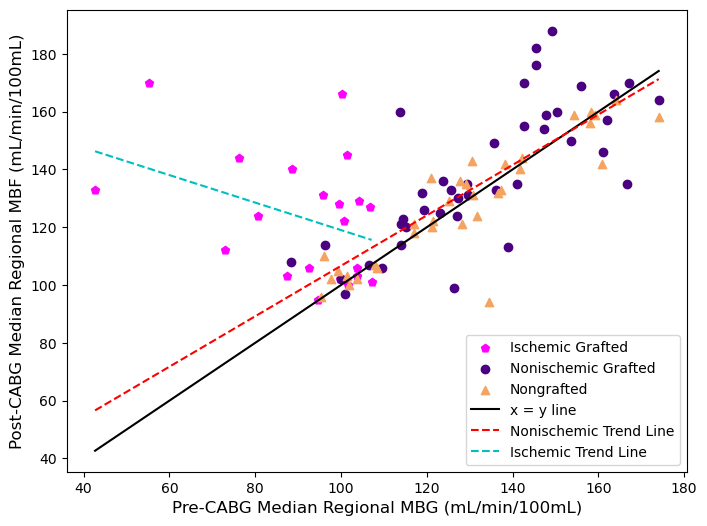

In [224]:
plt.figure(figsize=(8, 6))

plt.scatter(ischemic_median_A, ischemic_median_B, marker = 'p', color = 'fuchsia', label = 'Ischemic Grafted')
plt.scatter(nonischemic_grafted_A, nonischemic_grafted_B, marker = 'o', color = 'indigo', label = "Nonischemic Grafted")
plt.scatter(nongrafted_median_A, nongrafted_median_B, marker = '^', color = 'sandybrown', label = "Nongrafted")

x_fit = np.linspace(min(grafted_median_A), max(grafted_median_A), 100)
plt.plot(x_fit, x_fit, 'k-', label = "x = y line")

slope, intercept, _, _, _ = linregress(nonischemic_median_A, nonischemic_median_B)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, 'r--', label= "Nonischemic Trend Line")

slope, intercept, _, _, _ = linregress(ischemic_median_A, ischemic_median_B)
x_fit = np.linspace(min(ischemic_median_A), max(ischemic_median_A), 100)
y_fit = slope * x_fit + intercept
plt.plot(x_fit, y_fit, 'c--', label= "Ischemic Trend Line")


plt.xlabel("Pre-CABG Median Regional MBG (mL/min/100mL)", fontsize = 12)
plt.ylabel("Post-CABG Median Regional MBF (mL/min/100mL)", fontsize = 12)
plt.legend()
plt.show()

ValueError: Expected 2D array, got 1D array instead:
array=[ 42.6797953  129.43671596  76.32023393 147.39218733 100.21828033
 155.96926133 163.54880151 142.57048924 114.01045108 114.01045108
 106.82440034  94.7467132  113.68913793  88.43257162 150.40047171
  55.15386579 142.67777393 147.82623911  72.95592854 135.61370283
 104.28481569 166.72359736 174.07047575  96.19356483  87.37731077
 123.67343259 119.41974821 149.25798615 167.20737617 145.41168829
 100.95599394 101.75086859 106.52011643 161.03785447 145.35223346
 162.08356253  95.90627973 118.82385041 101.4064967  127.37608936
 125.56936594  88.53153598 115.10917659 100.11589492  92.43650733
 109.50181309  99.72325521 100.77788037 127.1435094  107.13520165
 103.67853559 136.02771847 126.40798483  80.66099006 103.72727224
 114.49683792 129.5955701  138.95946878 153.58787241 141.04924073
 122.98852317  99.65131255].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

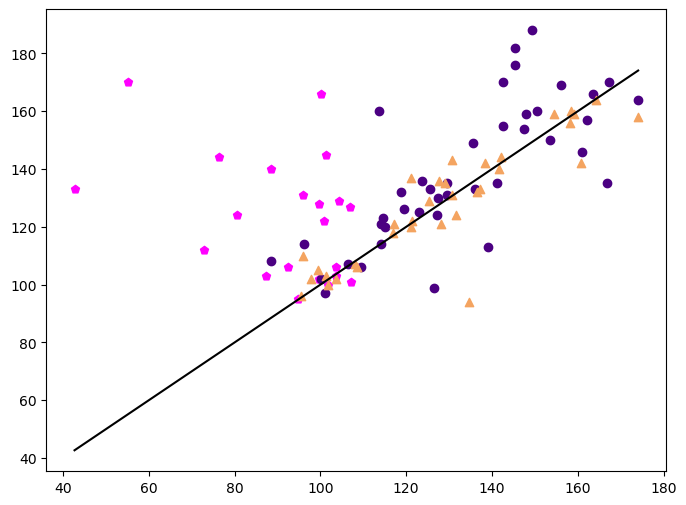

In [226]:
plt.figure(figsize=(8, 6))

plt.scatter(ischemic_median_A, ischemic_median_B, marker = 'p', color = 'fuchsia', label = 'Ischemic Grafted')
plt.scatter(nonischemic_grafted_A, nonischemic_grafted_B, marker = 'o', color = 'indigo', label = "Nonischemic Grafted")
plt.scatter(nongrafted_median_A, nongrafted_median_B, marker = '^', color = 'sandybrown', label = "Nongrafted")

x_fit = np.linspace(min(grafted_median_A), max(grafted_median_A), 100)
plt.plot(x_fit, x_fit, 'k-', label = "x = y line")

deg = 2
poly = PolynomialFeatures(degree=deg)
x_poly = poly.fit_transform(grafted_median_A)

LinReg = LinearRegression()
LinReg.fit(x_poly, grafted_median_B)

x_new = np.linspace(grafted_median_A.min(), grafted_median_A.max(), 100).reshape(-1,1)
x_new_poly = poly.transform(x_new)
y_pred = LinReg.predict(x_new_poly)

plt.plot(x_new_poly, y_pred, color = 'r', label=f"Polynomial Regression, deg = {deg}")

plt.xlabel("Pre-CABG Median Regional MBG (mL/min/100mL)", fontsize = 12)
plt.ylabel("Post-CABG Median Regional MBF (mL/min/100mL)", fontsize = 12)
plt.legend()
plt.show()

# Thresholding on index MBF

In [ ]:
volume_data_ischemic = []
volume_data_nonischemic = []
Removed_Cases_volume = Removed_Cases + ['SU03']
for patient_id in patient_ids:
    if patient_id in Removed_Cases_volume: 
        continue
    
    normalization_method = "classic"
    for file in VTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = Normalize(ReadVTUFile(file), normalization_method)
        elif f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = Normalize(ReadVTUFile(file), normalization_method)

    nonischemic_grid_A = ThresholdByUpper(MBF_A, "IndexMBF", 0.8)
    nonischemic_grid_B = ThresholdByUpper(MBF_B, "IndexMBF", 0.8)

    IschemicVolume_A = (GetVolume(MBF_A) - GetVolume(nonischemic_grid_A))/GetVolume(MBF_A)*100
    IschemicVolume_B = (GetVolume(MBF_B) - GetVolume(nonischemic_grid_B))/GetVolume(MBF_B)*100

    ischemia_presence = list(df[df["patient_id"] == patient_id]["is_ischemic"])
    is_ischemic = any(ischemia_presence)
    if is_ischemic:
        volume_data_ischemic.append({
            "patient_id": patient_id,
            "Volume_A": IschemicVolume_A,
            "Volume_B": IschemicVolume_B
        })
    else:
        volume_data_nonischemic.append({
            "patient_id": patient_id,
            "Volume_A": IschemicVolume_A,
            "Volume_B": IschemicVolume_B
        })

volume_data_ischemic = pd.DataFrame(volume_data_ischemic)
volume_data_nonischemic = pd.DataFrame(volume_data_nonischemic)

volume_entire_cohort = pd.concat([volume_data_ischemic, volume_data_nonischemic], ignore_index=True)

In [ ]:
df_A = pd.DataFrame({
    'Volume': np.concatenate([volume_data_ischemic["Volume_A"], volume_data_nonischemic["Volume_A"], volume_entire_cohort["Volume_A"]]),
    'Case': ['Ischemic\n Cases'] * len(volume_data_ischemic["Volume_A"]) +
            ['NonIschemic\n Cases'] * len(volume_data_nonischemic["Volume_A"]) +
            ['Entire Cohort'] * len(volume_entire_cohort["Volume_A"]),
    'Type': ['Pre-CABG'] * (len(volume_data_ischemic["Volume_A"]) + len(volume_data_nonischemic["Volume_A"]) + len(volume_entire_cohort["Volume_A"]))
})

df_B = pd.DataFrame({
    'Volume': np.concatenate([volume_data_ischemic["Volume_B"], volume_data_nonischemic["Volume_B"], volume_entire_cohort["Volume_B"]]),
    'Case': ['Ischemic\n Cases'] * len(volume_data_ischemic["Volume_B"]) +
            ['NonIschemic\n Cases'] * len(volume_data_nonischemic["Volume_B"]) +
            ['Entire Cohort'] * len(volume_entire_cohort["Volume_B"]),
    'Type': ['Post-CABG'] * (len(volume_data_ischemic["Volume_B"]) + len(volume_data_nonischemic["Volume_B"]) + len(volume_entire_cohort["Volume_B"]))
})

df_long = pd.concat([df_A, df_B], ignore_index=True)

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x='Case', y='Volume', hue='Type', data= df_long, showfliers=False, width = 0.4, palette={'Pre-CABG':'paleturquoise', 'Post-CABG':'coral'})

ax.set_ylabel("Volume of Ischemic Regions (%)", fontsize = 15)
ax.tick_params(axis='x', rotation=0, labelsize=11)
ax.legend(loc = 'lower left')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(6,5))

for i in range(len(volume_data_ischemic)):
    if i == 0:
        plt.plot([0, 1], [volume_data_ischemic["Volume_A"][i], volume_data_ischemic["Volume_B"][i]], marker = "o", color = "orange", label = "Ischemic")
    else:
        plt.plot([0, 1], [volume_data_ischemic["Volume_A"][i], volume_data_ischemic["Volume_B"][i]], marker = "o", color = "orange", label = None)
for i in range(len(volume_data_nonischemic)):
    if i == 0:
        plt.plot([0, 1], [volume_data_nonischemic["Volume_A"][i], volume_data_nonischemic["Volume_B"][i]], marker = "p", color = "lightblue", label = "NonIschemic")
    else:
        plt.plot([0, 1], [volume_data_nonischemic["Volume_A"][i], volume_data_nonischemic["Volume_B"][i]], marker = "p", color = "lightblue", label = None)
plt.xticks([0, 1], ["Pre-CABG", "Post-CABG"])
plt.ylabel("Volume of Ischemic Regions (%)")
plt.legend()
plt.show()

In [ ]:
def GetStats(dataframe):
    q1, q2, q3 = np.percentile(dataframe, [25, 50, 75])
    average = np.mean(dataframe)
    std = np.std(dataframe)
    return q2, q3-q1, average, std

print("TerritoryTag", "Median", "IQR", "Mean", "std")
volume_ischemic_A = np.concatenate([volume_data_ischemic["Volume_A"]])
print("Volume of Ischemic Regions (Ischemic Cases) Pre-CABG: ", GetStats(volume_ischemic_A))

volume_ischemic_B = np.concatenate([volume_data_ischemic["Volume_B"]])
print("Volume of Ischemic Regions (Ischemic Cases) Post-CABG: ", GetStats(volume_ischemic_B))

volume_nonischemic_A = np.concatenate([volume_data_nonischemic["Volume_A"]])
print("Volume of Ischemic Regions (Nonischemic Cases) Pre-CABG: ", GetStats(volume_nonischemic_A))

volume_nonischemic_B = np.concatenate([volume_data_nonischemic["Volume_B"]])
print("Volume of Ischemic Regions (Nonischemic Cases) Post-CABG: ", GetStats(volume_nonischemic_B))

EntireCohort_A = np.concatenate([volume_entire_cohort["Volume_A"]])
print("Volume of Ischemic Regions (Entire Dataset) Pre-CABG: ", GetStats(EntireCohort_A))

EntireCohort_B = np.concatenate([volume_entire_cohort["Volume_B"]])
print("Volume of Ischemic Regions (Entire Dataset) Post-CABG: ", GetStats(EntireCohort_B))

# Analyzing Based on the Graft Type

In [ ]:
grafts = sorted(set(PatientMetadata["graft"]))
print(grafts)

In [ ]:
print(PatientMetadata["graft"].value_counts())

In [ ]:
print(len(df["tag"]))
print(df["tag"].value_counts())

In [ ]:
print(PatientMetadata["NG"].value_counts())

In [ ]:
LIMA_mbf_A = np.concatenate(df[df['graft_type'] == 'LIMA']['absMBF_A'].values)
LIMA_mbf_B = np.concatenate(df[df['graft_type'] == 'LIMA']['absMBF_B'].values)

Radial_mbf_A = np.concatenate(df[df['graft_type'] == 'Radial']['absMBF_A'].values)
Radial_mbf_B = np.concatenate(df[df['graft_type'] == 'Radial']['absMBF_B'].values)

SVG_mbf_A = np.concatenate(df[df['graft_type'] == 'SVG']['absMBF_A'].values)
SVG_mbf_B = np.concatenate(df[df['graft_type'] == 'SVG']['absMBF_B'].values)

In [ ]:
df_A = pd.DataFrame({
    'MBF': np.concatenate([LIMA_mbf_A, Radial_mbf_A, SVG_mbf_A]),
    'Graft': ['LIMA'] * len(LIMA_mbf_A) +
                ['Radial'] * len(Radial_mbf_A) +
                ['SVG'] * len(SVG_mbf_A),
    'Type': ['Pre-CABG'] * (len(LIMA_mbf_A) + len(Radial_mbf_A) + len(SVG_mbf_A))
})

df_B = pd.DataFrame({
    'MBF': np.concatenate([LIMA_mbf_B, Radial_mbf_B, SVG_mbf_B]),
    'Graft': ['LIMA'] * len(LIMA_mbf_B) +
                ['Radial'] * len(Radial_mbf_B) +
                ['SVG'] * len(SVG_mbf_B),
    'Type': ['Post-CABG'] * (len(LIMA_mbf_B) + len(Radial_mbf_B) + len(SVG_mbf_B))
})

df_long = pd.concat([df_A, df_B], ignore_index=True)

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x='Graft', y='MBF', hue='Type', data= df_long, showfliers=False, width = 0.4, palette={'Pre-CABG':'plum', 'Post-CABG':'gold'})

ax.set_ylabel("Absolute MBF (mL/min/100mL)", fontsize = 15)
ax.tick_params(axis='x', rotation=0, labelsize=11)
ax.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

## Comparing the volume fed by each graft

In [ ]:
LIMA_volume_A = []
LIMA_volume_B = []

Radial_volume_A = []
Radial_volume_B = []

SVG_volume_A = []
SVG_volume_B = []

Removed_Cases_volume = Removed_Cases + ['SU03']

for patient_id in patient_ids:
    if patient_id in Removed_Cases_volume: 
        continue
    tags = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['stenosis tag'])
    TerritoryTags = [f'post_{tag}' for tag in tags]
    grafts = list(PatientMetadata[PatientMetadata['patient-id'] == patient_id]['graft'])
    for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file
    MBF_Labels = ReadLabels(LabelFile, TerritoryTags)
    normalization_method = "classic"
    for file in VTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = Normalize(ReadVTUFile(file), normalization_method)
        elif f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = Normalize(ReadVTUFile(file), normalization_method)

        for tag in tags:
            graft = PatientMetadata[(PatientMetadata['patient-id'] == patient_id) & (PatientMetadata['stenosis tag'] == tag)]['graft']
            if graft.iloc[0] == 'LIMA':
                LIMA_volume_A.append(GetRegionVolume(MBF_A, MBF_Labels, tag))
                LIMA_volume_B.append(GetRegionVolume(MBF_B, MBF_Labels, tag))
            if graft.iloc[0] == 'Radial':
                Radial_volume_A.append(GetRegionVolume(MBF_A, MBF_Labels, tag))
                Radial_volume_B.append(GetRegionVolume(MBF_B, MBF_Labels, tag))
            if graft.iloc[0] == 'SVG':
                SVG_volume_A.append(GetRegionVolume(MBF_A, MBF_Labels, tag))
                SVG_volume_B.append(GetRegionVolume(MBF_B, MBF_Labels, tag))

LIMA_volume_A = np.array(LIMA_volume_A)
LIMA_volume_B = np.array(LIMA_volume_B)

Radial_volume_A = np.array(Radial_volume_A)
Radial_volume_B = np.array(Radial_volume_B)

SVG_volume_A = np.array(SVG_volume_A)
SVG_volume_B = np.array(SVG_volume_B)



### Box Plot

In [ ]:
df_A = pd.DataFrame({
    'Volume': np.concatenate([LIMA_volume_A, Radial_volume_A, SVG_volume_A]),
    'Graft':
        ['LIMA'] * len(LIMA_volume_A) +
        ['Radial'] * len(Radial_volume_A) +
        ['SVG'] * len(SVG_volume_A),
    'Type': ['Pre-CABG'] * (len(LIMA_volume_A) + len(Radial_volume_A) + len(SVG_volume_A))
})

df_B = pd.DataFrame({
    'Volume': np.concatenate([LIMA_volume_B, Radial_volume_B, SVG_volume_B]),
    'Graft':
        ['LIMA'] * len(LIMA_volume_B) +
        ['Radial'] * len(Radial_volume_B) +
        ['SVG'] * len(SVG_volume_B),
    'Type': ['Post-CABG'] * (len(LIMA_volume_B) + len(Radial_volume_B) + len(SVG_volume_B))
})

df_long = pd.concat([df_A, df_B], ignore_index=True)

In [ ]:
plt.figure(figsize=(5, 5))
ax = sns.boxplot(x='Graft', y='Volume', hue='Type', data= df_B, showfliers=False, width = 0.4, palette={'Pre-CABG':'plum', 'Post-CABG':'azure'})

ax.set_ylabel("Volume (mL)", fontsize = 15)
ax.tick_params(axis='x', rotation=0, labelsize=11)
ax.legend(loc = 'upper right')
plt.tight_layout()
plt.show()

## Statistical Analysis: Kruskal-Wallis test on the differences of median MBF per graft type

In [ ]:
LIMA_d_median_mbf = []
Radial_d_median_mbf = []
SVG_d_median_mbf = []

for patient_id in patient_ids:
    df_patient = df[df["patient_id"] == patient_id]
    if df_patient.empty:
        print(f"Patient {patient_id} not found in DataFrame. Skipping.")
        continue
    
    grafts = list(df[df["patient_id"] == patient_id]["graft_type"])
    for graft in grafts:
        if graft:
            median_A = np.median(df[(df["patient_id"] == patient_id) & (df["graft_type"] == graft)]["absMBF_A"].iloc[0])
            median_B = np.median(df[(df["patient_id"] == patient_id) & (df["graft_type"] == graft)]["absMBF_B"].iloc[0])
        diff = median_B - median_A
        if graft == "LIMA":
            LIMA_d_median_mbf.append(diff)
        elif graft == "Radial":
            Radial_d_median_mbf.append(diff)
        elif graft == "SVG":
            SVG_d_median_mbf.append(diff)
        else:
            pass



In [ ]:
stat, p = kruskal(LIMA_d_median_mbf, Radial_d_median_mbf, SVG_d_median_mbf)
print(p)
if p > 0.05:
    print("There is no significant difference in improvement (ΔMBF) between different graft types.")
else:
    print("There is a difference—at least one graft type shows a significantly different median improvement.")

# Territory-based analysis

In [ ]:
def TerritorySelection(tag):
    if any(sub in tag.lower() for sub in ["lcx", "om", "intermedius"]):
        territory = "LCx"
    elif any(sub in tag.lower() for sub in ["lad", "diag"]):
        territory = "LAD"
    elif any(sub in tag.lower() for sub in ["pda", "pl"]):
        territory = "RCA"
    else:
        print(f"{tag} was not assigned to any specific territory.")
        territory = None
    
    return territory

def TerritoryAssignment(MBF, InputLabels, ScalarArray):
    
    Territories = {"LAD":None, "LCx":None, "RCA":None}
    Territory_ids = {"LAD":[], "LCx":[], "RCA":[]}
    with open(InputLabels, "r") as ifile:
        for i, LINE in enumerate(ifile):
            if i == 0: 
                continue
            line = LINE.strip().split()
            label = line[1]
            id_value = int(line[0])

            
            territory_tag = TerritorySelection(label)
            if territory_tag is not None:
                Territory_ids[territory_tag].append(id_value)
    
    for tag, ids in Territory_ids.items():
        TerritoryAppend = vtk.vtkAppendFilter()
        for id in ids:
            territory = ThresholdInBetween(MBF, "TerritoryMaps", id, id)
            TerritoryAppend.AddInputData(territory)
        TerritoryAppend.Update()
        Territory = TerritoryAppend.GetOutput()
        MBFArray = vtk_to_numpy(Territory.GetPointData().GetArray(ScalarArray))
        Territories[tag] = MBFArray

    return Territories


MappedVTUFiles = glob.glob(f"{opath}/*.vtu")

LAD_MBF_A = []
LAD_MBF_B = []

LCx_MBF_A = []
LCx_MBF_B = []

RCA_MBF_A = []
RCA_MBF_B = []
Removed_Cases_ = Removed_Cases + ["VA13"]
for patient_id in patient_ids:
    if patient_id in Removed_Cases_: 
        continue
    print(patient_id)

    for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file

    for file in MappedVTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = ReadVTUFile(file)
    for file in VTUFiles:
        if f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = ReadVTUFile(file)
    
    for i in range(MBF_B.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF_B.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ScalarArray_B = arrayname_
    
    MappedScalarArrayName = "MappedScalar"
    territory_A = TerritoryAssignment(MBF_A, LabelFile, MappedScalarArrayName)
    territory_B = TerritoryAssignment(MBF_B, LabelFile, ScalarArray_B)

    LAD_MBF_A.append(territory_A["LAD"])
    LAD_MBF_B.append(territory_B["LAD"])

    LCx_MBF_A.append(territory_A["LCx"])
    LCx_MBF_B.append(territory_B["LCx"])

    RCA_MBF_A.append(territory_A["RCA"])
    RCA_MBF_B.append(territory_B["RCA"])

LAD_MBF_A = np.concatenate(LAD_MBF_A)
LAD_MBF_B = np.concatenate(LAD_MBF_B)

LCx_MBF_A = np.concatenate(LCx_MBF_A)
LCx_MBF_B = np.concatenate(LCx_MBF_B)

RCA_MBF_A = np.concatenate(RCA_MBF_A)
RCA_MBF_B = np.concatenate(RCA_MBF_B)

In [ ]:


df_A = pd.DataFrame({
    'MBF': np.concatenate([LAD_MBF_A, LCx_MBF_A, RCA_MBF_A]),
    'Territory': ["LAD"] * len(LAD_MBF_A) +
                ["LCx"] * len(LCx_MBF_A) +
                ["RCA"] * len(RCA_MBF_A),
    'Type': ['Pre-CABG'] * (len(LAD_MBF_A) + len(LCx_MBF_A) + len(RCA_MBF_A))
})

df_B = pd.DataFrame({
    'MBF': np.concatenate([LAD_MBF_B, LCx_MBF_B, RCA_MBF_B]),
    'Territory': ["LAD"] * len(LAD_MBF_B) +
                ["LCx"] * len(LCx_MBF_B) +
                ["RCA"] * len(RCA_MBF_B),
    'Type': ['Post-CABG'] * (len(LAD_MBF_B) + len(LCx_MBF_B) + len(RCA_MBF_B))
})

df_long = pd.concat([df_A, df_B], ignore_index=True)

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x='Territory', y='MBF', hue='Type', data= df_long, showfliers=False, width = 0.4, palette={'Pre-CABG':'plum', 'Post-CABG':'gold'})

ax.set_ylabel("Absolute MBF (mL/min/100mL)", fontsize = 15)
ax.tick_params(axis='x', rotation=0, labelsize=11)
ax.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

# Territory-Based Analysis Downstream a Stenosis

In [ ]:
tags_unique = sorted(set(PatientMetadata["stenosis tag"]))
print(tags_unique)

In [ ]:
tags_dataframe = sorted(set(df["tag"]))
print(tags_dataframe)

In [ ]:
#Is ischemic

LAD_MBF_A = np.concatenate(df[(df["tag"].isin(["LAD", "Diag"])) & (df["is_ischemic"] == True)]["absMBF_A"].values)
LAD_MBF_B = np.concatenate(df[(df["tag"].isin(["LAD", "Diag"]))& (df["is_ischemic"] == True)]["absMBF_B"].values)

LCx_MBF_A = np.concatenate(df[(df["tag"].isin(["LCx", "Ramus", "OM"])) & (df["is_ischemic"] == True)]["absMBF_A"].values)
LCx_MBF_B = np.concatenate(df[(df["tag"].isin(["LCx", "Ramus", "OM"])) & (df["is_ischemic"] == True)]["absMBF_B"].values)

RCA_MBF_A = np.concatenate(df[(df["tag"].isin(["PDA", "RCA"])) & (df["is_ischemic"] == True)]["absMBF_A"].values)
RCA_MBF_B = np.concatenate(df[(df["tag"].isin(["PDA", "RCA"])) & (df["is_ischemic"] == True)]["absMBF_B"].values)

In [ ]:
df_A = pd.DataFrame({
    'MBF': np.concatenate([LAD_MBF_A, LCx_MBF_A, RCA_MBF_A]),
    'Territory': ["LAD"] * len(LAD_MBF_A) +
                ["LCx"] * len(LCx_MBF_A) +
                ["RCA"] * len(RCA_MBF_A),
    'Type': ['Pre-CABG'] * (len(LAD_MBF_A) + len(LCx_MBF_A) + len(RCA_MBF_A))
})

df_B = pd.DataFrame({
    'MBF': np.concatenate([LAD_MBF_B, LCx_MBF_B, RCA_MBF_B]),
    'Territory': ["LAD"] * len(LAD_MBF_B) +
                ["LCx"] * len(LCx_MBF_B) +
                ["RCA"] * len(RCA_MBF_B),
    'Type': ['Post-CABG'] * (len(LAD_MBF_B) + len(LCx_MBF_B) + len(RCA_MBF_B))
})

df_long = pd.concat([df_A, df_B], ignore_index=True)

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x='Territory', y='MBF', hue='Type', data= df_long, showfliers=False, width = 0.4, fill= False, gap=.1, palette={'Pre-CABG':'green', 'Post-CABG':'orangered'}, medianprops={"color": "k", "linewidth": 2})

ax.set_ylabel("Absolute MBF (mL/min/100mL)", fontsize = 15)
ax.tick_params(axis='x', rotation=0, labelsize=11)
plt.title("Comparing Ischemic Territories Pre/Post-CABG")
ax.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

In [ ]:
#Is not ischemic

LAD_MBF_A = np.concatenate(df[(df["tag"].isin(["LAD", "Diag"])) & (df["is_ischemic"] == False)]["absMBF_A"].values)
LAD_MBF_B = np.concatenate(df[(df["tag"].isin(["LAD", "Diag"]))& (df["is_ischemic"] == False)]["absMBF_B"].values)

LCx_MBF_A = np.concatenate(df[(df["tag"].isin(["LCx", "Ramus", "OM"])) & (df["is_ischemic"] == False)]["absMBF_A"].values)
LCx_MBF_B = np.concatenate(df[(df["tag"].isin(["LCx", "Ramus", "OM"])) & (df["is_ischemic"] == False)]["absMBF_B"].values)

RCA_MBF_A = np.concatenate(df[(df["tag"].isin(["PDA", "RCA"])) & (df["is_ischemic"] == False)]["absMBF_A"].values)
RCA_MBF_B = np.concatenate(df[(df["tag"].isin(["PDA", "RCA"])) & (df["is_ischemic"] == False)]["absMBF_B"].values)

In [ ]:
df_A = pd.DataFrame({
    'MBF': np.concatenate([LAD_MBF_A, LCx_MBF_A, RCA_MBF_A]),
    'Territory': ["LAD"] * len(LAD_MBF_A) +
                ["LCx"] * len(LCx_MBF_A) +
                ["RCA"] * len(RCA_MBF_A),
    'Type': ['Pre-CABG'] * (len(LAD_MBF_A) + len(LCx_MBF_A) + len(RCA_MBF_A))
})

df_B = pd.DataFrame({
    'MBF': np.concatenate([LAD_MBF_B, LCx_MBF_B, RCA_MBF_B]),
    'Territory': ["LAD"] * len(LAD_MBF_B) +
                ["LCx"] * len(LCx_MBF_B) +
                ["RCA"] * len(RCA_MBF_B),
    'Type': ['Post-CABG'] * (len(LAD_MBF_B) + len(LCx_MBF_B) + len(RCA_MBF_B))
})

df_long = pd.concat([df_A, df_B], ignore_index=True)

In [ ]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(x='Territory', y='MBF', hue='Type', data= df_long, showfliers=False, width = 0.4, fill= False, gap=.1, palette={'Pre-CABG':'green', 'Post-CABG':'orangered'}, medianprops={"color": "k", "linewidth": 2})

ax.set_ylabel("Absolute MBF (mL/min/100mL)", fontsize = 15)
ax.tick_params(axis='x', rotation=0, labelsize=11)
plt.title("Comparing Nonischemic Territories Pre/Post-CABG")
ax.legend(loc = 'upper left')
plt.tight_layout()
plt.show()

# Cumulative Distribution Function

to do:
 - Add area under the curve below the threshold
 - Add statistical test for comparing the distributions (?)

In [ ]:
def cumdist(Array):
    array = np.sort(Array)
    threshold = 0.8 
    cdf = np.arange(1, len(array) + 1)/len(array) * 100
    idx = np.searchsorted(array, threshold, side='right') - 1
    cdf_at_threshold = cdf[idx] if idx >= 0 else 0

    x = array[array < threshold]
    y = cdf[array < threshold]
    AUC = np.trapz(y,x)
    
    return array, cdf, threshold, cdf_at_threshold, AUC

In [ ]:
for patient_id in patient_ids:
    if patient_id in Removed_Cases: 
        continue

    ischemia_presence = list(df[df["patient_id"] == patient_id]["is_ischemic"])
    is_ischemic = any(ischemia_presence)

    if is_ischemic:
        print(patient_id)

In [ ]:
print(Removed_Cases)

In [ ]:
ScalarArray_A_Agg_Ischemic = []
ScalarArray_B_Agg_Ischemic = []

ScalarArray_A_Agg_Nonischemic = []
ScalarArray_B_Agg_Nonischemic = []

for patient_id in patient_ids:
    if patient_id in Removed_Cases: 
        continue
    #print(patient_id)

    """for file in TerritoryLabels:
        if patient_id in os.path.basename(os.path.splitext(file)[0]):
            LabelFile = file"""

    for file in MappedVTUFiles:
        if f"{patient_id}A" in os.path.basename(os.path.splitext(file)[0]):
            MBF_A = ReadVTUFile(file)
    for file in VTUFiles:#MappedVTUFiles:#
        if f"{patient_id}B" in os.path.basename(os.path.splitext(file)[0]):
            MBF_B = ReadVTUFile(file)
    
    for i in range(MBF_A.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF_A.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ScalarArray_A_Name = arrayname_
    
    for i in range(MBF_B.GetPointData().GetNumberOfArrays()):
        arrayname_ = MBF_B.GetPointData().GetArrayName(i)
        if 'scalars' in arrayname_.lower():
            ScalarArray_B_Name = arrayname_
    
    MappedScalarArrayName = "MappedScalar"
    ScalarArray_A = vtk_to_numpy(MBF_A.GetPointData().GetArray(MappedScalarArrayName))#ScalarArray_A_Name))#
    ScalarArray_A_ = ScalarArray_A/np.percentile(ScalarArray_A, 75)
    ScalarArray_B = vtk_to_numpy(MBF_B.GetPointData().GetArray(ScalarArray_B_Name))
    ScalarArray_B_ = ScalarArray_B/np.percentile(ScalarArray_B, 75)
    

    ischemia_presence = list(df[df["patient_id"] == patient_id]["is_ischemic"])
    is_ischemic = any(ischemia_presence)


    if is_ischemic:
        ScalarArray_A_Agg_Ischemic.append(ScalarArray_A_)
        ScalarArray_B_Agg_Ischemic.append(ScalarArray_B_)
    else:
        ScalarArray_A_Agg_Nonischemic.append(ScalarArray_A_)
        ScalarArray_B_Agg_Nonischemic.append(ScalarArray_B_)



In [ ]:
array_A, cdf_A, threshold_A, cdf_threshold_A, AUC_ischemic_A = cumdist(np.concatenate(ScalarArray_A_Agg_Ischemic))
array_B, cdf_B, threshold_B, cdf_threshold_B, AUC_ischemic_B = cumdist(np.concatenate(ScalarArray_B_Agg_Ischemic))

x_AUC_A = array_A[array_A < threshold_A]
y_AUC_A = cdf_A[array_A < threshold_A]

x_AUC_B = array_B[array_B < threshold_B]
y_AUC_B = cdf_B[array_B < threshold_B]

plt.figure(figsize=(8, 6))
plt.plot(array_A, cdf_A, color = "green", label = "Pre-CABG")
plt.plot(array_B, cdf_B, color = "orangered", label = "Post-CABG")
plt.plot([0.8, 0.8], [0, max(cdf_threshold_A, cdf_threshold_B)], 'k--', label = "cut-off = 0.8")
plt.fill_between(x_AUC_A, y_AUC_A, color = 'lightgreen', alpha = 0.4, label= f"AUC Pre-CABG = {int(AUC_ischemic_A*100)/100}")
plt.fill_between(x_AUC_B, y_AUC_B, color = 'lightsalmon', alpha = 0.4, label= f"AUC Post-CABG = {int(AUC_ischemic_B*100)/100}")

#plt.xlim(-100, 500)
plt.xlim(0, 2)
plt.title("Ischemic Cases (>10% drop)")
plt.xlabel("Index MBF", fontsize = 12)
plt.ylabel("Cumulative Distribution Function (%)", fontsize = 12)
plt.legend()
plt.show()

In [ ]:
array_A, cdf_A, threshold_A, cdf_threshold_A, AUC_A = cumdist(np.concatenate(ScalarArray_A_Agg_Nonischemic))
array_B, cdf_B, threshold_B, cdf_threshold_B, AUC_B = cumdist(np.concatenate(ScalarArray_B_Agg_Nonischemic))

x_AUC_A = array_A[array_A < threshold_A]
y_AUC_A = cdf_A[array_A < threshold_A]

x_AUC_B = array_B[array_B < threshold_B]
y_AUC_B = cdf_B[array_B < threshold_B]

plt.figure(figsize=(8, 6))
plt.plot(array_A, cdf_A, color = "green", label = "Pre-CABG")
plt.plot(array_B, cdf_B, color = "orangered", label = "Post-CABG")
plt.plot([0.8, 0.8], [0, max(cdf_threshold_A, cdf_threshold_B)], 'k--', label = "cut-off = 0.8")
plt.fill_between(x_AUC_A, y_AUC_A, color = 'lightgreen', alpha = 0.4, label= f"AUC Pre-CABG = {int(AUC_A*100)/100}")
plt.fill_between(x_AUC_B, y_AUC_B, color = 'lightsalmon', alpha = 0.4, label= f"AUC Post-CABG = {int(AUC_B*100)/100}")


#plt.xlim(-100, 500)
plt.xlim(0, 2)
plt.title("Nonischemic Cases")
plt.xlabel("Index MBF", fontsize = 12)
plt.ylabel("Cumulative Distribution Function (%)", fontsize = 12)
plt.legend()
plt.show()